<a href="https://colab.research.google.com/github/visheshgupta19/XAI_Court/blob/main/XAI_Court.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 👩‍⚖️ ⚖️ Machine Learning Court

## ⚖️ Case: Recidivism Risk – COMPAS Dataset
#### 🔍 Scenario
Malik Johnson, a 27-year-old with one prior felony, was flagged as low risk by an AI risk assessment tool and granted parole. Some community stakeholders have questioned whether this was an appropriate classification.

#### 🟥 Prosecution
Examine whether the model may have underestimated risk factors. Use explanation techniques to uncover potential oversights or inconsistencies.

In [1]:
import numpy as np
import random, os

# set seed to maintain consistency
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [2]:
# ⚖️ Case 3: Recidivism Prediction (COMPAS Dataset)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names*")

# Load dataset
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
df_compas = pd.read_csv(url)

# Filter relevant columns and preprocess
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree']
df = df_compas[features + ['two_year_recid']].dropna()
df = df[df['c_charge_degree'].isin(['F', 'M'])]  # Filter valid degrees

# Encode categoricals
df = df.copy()
df['sex'] = df['sex'].astype('category').cat.codes
df['race'] = df['race'].astype('category').cat.codes
df['c_charge_degree'] = df['c_charge_degree'].astype('category').cat.codes

X = df[features]
y = df['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_compas = RandomForestClassifier(random_state=42)
model_compas.fit(X_train, y_train)
print(classification_report(y_test, model_compas.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.68      0.68       823
           1       0.57      0.57      0.57       620

    accuracy                           0.63      1443
   macro avg       0.62      0.62      0.62      1443
weighted avg       0.63      0.63      0.63      1443



In [3]:
# 🎯 Focus Instance: Recidivism Risk Case (Malik Johnson)
focus_instance_compas = pd.DataFrame([{
    "age": 27,
    "sex": 1,  # Male
    "race": 1,  # African-American
    "priors_count": 1,
    "juv_fel_count": 0,
    "juv_misd_count": 0,
    "juv_other_count": 0,
    "c_charge_degree": 1  # Felony
}])

pred = model_compas.predict(focus_instance_compas)
print("Prediction for Malik Johnson (Recidivism):", pred)


Prediction for Malik Johnson (Recidivism): [0]


Based on the initial results above we notice that:

- Overall performance of the model is weak
The Accuracy is 63% which is extremely low. It means that 1 out of 3 cases the model tends to get wrong which is too risk to use as a means of evidence for parole decisions
- When you focus on Class 0 The precision/recall is 0.68 and for Class 1 it is 0.57 which indicates that the model does a better job correctly predicting “no recidivism” than “recidivism.” From this we could infer that the model is more biased towards predicting non-recidivism (class 0) and for high stake decisions, underestimating false negatives can be dangerous.



In [4]:
# look at the cleaned dataset:
df.head()

,age,sex,race,priors_count,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,two_year_recid
0,69,1,5,0,0,0,0,0,0
1,34,1,0,0,0,0,0,0,1
2,24,1,0,4,0,0,1,0,1
3,23,1,0,1,0,1,0,0,0
4,43,1,5,2,0,0,0,0,0


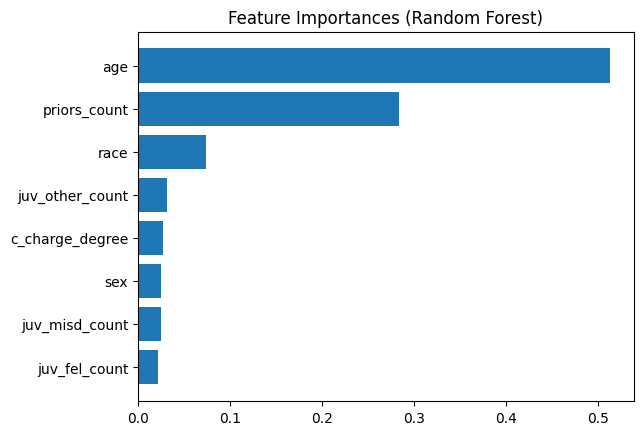

In [6]:
import matplotlib.pyplot as plt

# get numerical scores for each feature
importances = model_compas.feature_importances_
# extract feature name
feature_names = X.columns
# sort by score for mapping
sorted_idx = np.argsort(importances)

# map and plot
# used chatGpt to generate the plot. Prompt given: We have the importance and feature names, create a horizontal bar chart for better analysis.
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.title("Feature Importances (Random Forest)")
plt.show()


- From the plot above we notice that the main features based on importance are age and priors_counts. This would indicate that younger individuals are flagged higher risk compared to older individuals. Additionally more prior offenses also increase predicted risk.
- However we notice that while the model takes race as a feature which is not extremely high in importance it is being accounted for which can raise fairness concerns.
- Juvenile history and charge types are considered insignificant compared to age and priors however they might have importance context that should be considered.

## SHAP ANALYSIS

After my initial feature importance analysis I decided to go ahead and check my instance with SHAP as it would let us see which features most influenced Malik’s prediction. Since the set up used a RandomForestClassifier I decided to use a TreeExplainer.

My decision was based on my findings online in a medium article: https://medium.com/biased-algorithms/shap-values-for-random-forest-1150577563c9

The below code for the explainer and shap_values has also been taken from the medium article

In [7]:
pip install shap

In [8]:
import shap

In [9]:
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(model_compas)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

In [10]:
shap_values

array([[[ 0.24848777, -0.24848777],
        [ 0.01250618, -0.01250618],
        [ 0.02591521, -0.02591521],
        ...,
        [ 0.00756662, -0.00756662],
        [ 0.00670812, -0.00670812],
        [-0.01496316,  0.01496316]],

       [[-0.01500499,  0.01500499],
        [-0.03440406,  0.03440406],
        [-0.0060773 ,  0.0060773 ],
        ...,
        [ 0.00568548, -0.00568548],
        [ 0.00821314, -0.00821314],
        [ 0.00873223, -0.00873223]],

       [[ 0.2993961 , -0.2993961 ],
        [ 0.00228929, -0.00228929],
        [ 0.00186419, -0.00186419],
        ...,
        [ 0.0079402 , -0.0079402 ],
        [ 0.01306023, -0.01306023],
        [ 0.12608493, -0.12608493]],

       ...,

       [[ 0.18312316, -0.18312316],
        [ 0.00557321, -0.00557321],
        [ 0.04693616, -0.04693616],
        ...,
        [ 0.00790556, -0.00790556],
        [ 0.00770683, -0.00770683],
        [ 0.02304129, -0.02304129]],

       [[ 0.10467382, -0.10467382],
        [ 0.01448939, -0.01

In [11]:
# SHAP values for focus instance
malik_shap = explainer.shap_values(focus_instance_compas)

# extract for class 1 (recidivism)
malik_shap_class1 = malik_shap[0][:, 1]

shap_analysis = pd.DataFrame({
    'feature': focus_instance_compas.columns,
    'shap_value_class1': malik_shap_class1,
    'feature_value': focus_instance_compas.iloc[0].values
}).sort_values(by='shap_value_class1', key=abs, ascending=False)

shap_analysis


,feature,shap_value_class1,feature_value
3,priors_count,-0.141402,1
7,c_charge_degree,-0.092495,1
2,race,-0.067412,1
0,age,-0.032254,27
6,juv_other_count,-0.013080,0
4,juv_fel_count,-0.007660,0
5,juv_misd_count,-0.007649,0
1,sex,0.003839,1


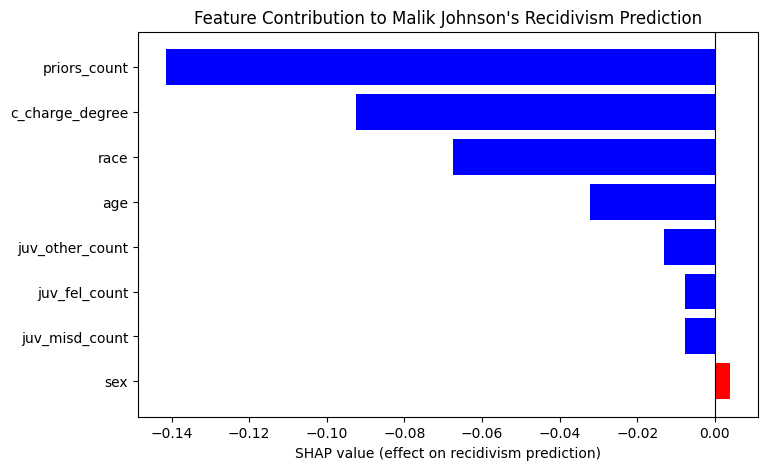

In [12]:
shap_analysis_sorted = shap_analysis.sort_values(by='shap_value_class1', key=abs, ascending=True)

# plot
plt.figure(figsize=(8,5))
colors = ['red' if x > 0 else 'blue' for x in shap_analysis_sorted['shap_value_class1']]
plt.barh(shap_analysis_sorted['feature'], shap_analysis_sorted['shap_value_class1'], color=colors)
plt.xlabel("SHAP value (effect on recidivism prediction)")
plt.title("Feature Contribution to Malik Johnson's Recidivism Prediction")
plt.axvline(0, color='black', linewidth=0.8)
plt.show()

For the plot above we must note that:

- Blue bars show negative SHAP values which means features are pushing toward non-recidivism
- Red bars show positive SHAP values which means features are pushing toward recidivism
- Length of the bar shows the magnitude of influence

From the data above we notice that:

1. There is an overweight on prior_count:
- We notice that prior_count has the largest negative value (-0.141) which seems to be dominating in the models decision. It looks like one prior for Malik is seen as strong evidence of low risk and is almost single handedly deterring the outcome.
- By having this feature being overweighed the model exposes itself to getting those cases wrong where priors could be a higher number due to policing disparity such as over policing towards certain communities in specific.

2. Minimal influence of other risk factors:
- It seems like Juvenile history, age and sex have very small contributions. This shows how the model is highly reliable on one feature only i.e. prior counts and potentially ignoring other risk signals. By mitigating these factors we can state that model is underweight evidence such as prior clean record at a juvenile stage and focusing solely on adult convictions

In court we require our models to influence bail or parole to be reliable and easily explainable however from our SHAP analysis above it seems to me that:
- There is an overemphasis on prior counts and ignoring of important features such as juvenile clean record
- We are also directly using race as a feature which should be protected according to the US constitutional and civil rights frameworks (Equal Protection Clause, Civil Rights Act). Even by having a contribution that is relatively small (-0.067) I believe allowing this to influence the decision is highly incorrect.

I strongly believe that while Malik's outcome may appear favorable, the factors that were taken into consideration to make the decision are extremely questionable. In our SHAP analysis, Race carried more weight than juvenile history or age. This could easily affect any other defendant with nearly the same profile, but this time, they could be marked as high risk because of an extra prior or the model using race that pushes it over the threshold. The distribution of importance given to the features is what makes me believe that the model is unreliable and incorrect to use in a decision as important as parole, as we cannot allow the decision of people's fate to lie in an algorithm that is fundamentally against the US constitutional and civil rights frameworks.

## ANCHOR ANALAYSIS

In [13]:
pip install alibi

In [14]:
from alibi.explainers import AnchorTabular

In [15]:
# function for the model
def predict_fn(X_array):
    return model_compas.predict(X_array)

To generate our anchors we:
- Take Malik’s feature values as a baseline.
- Pertube features
- Find minimal set of conditions that guarantees the same prediction above the threshold. I have set this to be 0.95

In [16]:
feature_names = X.columns.tolist()

explainer_anchor = AnchorTabular(predict_fn, feature_names, seed = SEED)
explainer_anchor.fit(X_train.values, disc_perc=[25, 50, 75])


AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 42, 'disc_perc': [25, 50, 75]},
  'version': '0.9.6'}
)

In [17]:
malik_array = focus_instance_compas.values

explanation = explainer_anchor.explain(malik_array, threshold=0.95)


In [18]:
anchor_rules = explanation.anchor
precision = explanation.precision
coverage = explanation.coverage

anchor_rules, precision, coverage


(['priors_count <= 2.00',
  'age > 25.00',
  '0.00 < c_charge_degree <= 1.00',
  '0.00 < race <= 2.00',
  'juv_fel_count <= 0.00',
  'sex <= 1.00',
  'juv_misd_count <= 0.00'],
 0.8972477064220183,
 0.0868)

- The anchor rules we see about are conditions on features that anchor the model prediction. Every time a record satisfies that set of conditions the model predicts 0 or low recidivism.
- We notice that we have a precision of 0.89 which indicates that when conditions are met then 89% of the time the model will predict low risk. However the rules only cover around 8% of the dataset that we have.
  - So ideally this would mean that in a dataset of around 100 examples the decision rules would cover only 8 of them and out of those 8 data points 89%  will have the model predict low risk.

From the above results and the rules we see we can notice that:


- Similar to SHAP Race is part of the anchor rule that raises serious constitution concerns.

- Felony charge doesn't increase risk by much. The anchor rules includes c_charge_degree <= 1.0 (Felony), yet it still anchors the low risk prediction. If we look at the real world a felony is serious and would ideally increase recidivism risk which seems to be ignored by our model in this case.

- Only 8% of the dataset matches the rules we have got which means that 92% has a different set of anchor rules. This indicates that the logic is narrow and may fail on different individuals. Maliks case is relatively an edge case with the model only people able to explain his case in a way that applies for less than 1 in 10 people. This makes the decision arbitrary and raises the question if Malik was fortunate to be classified as low risk and someone with nearly identical traits could easily be classified as high risk with subtle data differences. This in my mind make me question the models fairness and having such an algorithm dictate parole or no parole seems to be incorrect.

- Even when the rules hold our precision is only 89% and not 100%. This indicates thats the rules aren't capturing risk totally and in a sensitive topic like recidivism it is essential to try to get 100%.

In [19]:
pip install lime

In [20]:
import lime
import lime.lime_tabular

In [21]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train.values,
    feature_names = X_train.columns.tolist(),
    class_names = ['No Recidivism', 'Recidivism'],
    mode='classification',
    random_state=SEED
)

In [22]:
# instance to numpy array as LIME expects 1D array
malik_array = focus_instance_compas.values[0]

# explanation generation
lime_exp = explainer_lime.explain_instance(
    data_row = malik_array,
    predict_fn = model_compas.predict_proba,
    num_features = len(X.columns)
)


In [23]:
lime_features = lime_exp.as_list()

lime_features


[('juv_fel_count <= 0.00', -0.13770789849611495),
 ('0.00 < priors_count <= 2.00', -0.12496852836751841),
 ('juv_other_count <= 0.00', -0.08898138820388254),
 ('juv_misd_count <= 0.00', -0.07132913849790526),
 ('0.00 < c_charge_degree <= 1.00', -0.038742393520633155),
 ('25.00 < age <= 31.00', 0.0350063856189122),
 ('0.00 < race <= 2.00', 0.012871864468551125),
 ('sex <= 1.00', 0.0)]

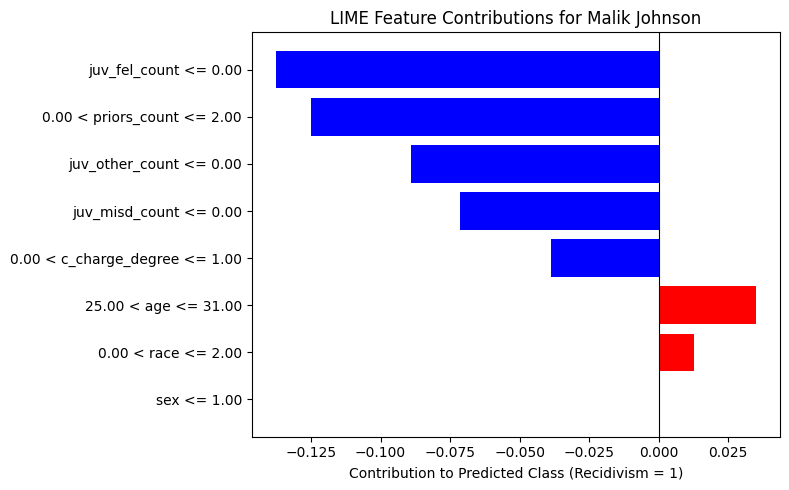

In [24]:
lime_df = pd.DataFrame(lime_features, columns=['feature', 'contribution'])
lime_df['abs_contribution'] = lime_df['contribution'].abs()
lime_df = lime_df.sort_values(by='abs_contribution', ascending=True)

# plot
plt.figure(figsize=(8,5))
plt.barh(lime_df['feature'], lime_df['contribution'], color=['blue' if x<0 else 'red' for x in lime_df['contribution']])
plt.xlabel('Contribution to Predicted Class (Recidivism = 1)')
plt.title('LIME Feature Contributions for Malik Johnson')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

For the plot above we must note that:

- Blue bars show features pushing prediction toward non-recidivism
- Red bars show features pushing prediction toward recidivism

From the data above we notice that:

- As seen in the model above race is again given importance in the model which is extremely problematic. The smallest of coefficients can cause bias.
- The model has a big reliance on prior and juvenile history: It looks like the top 4 most negative contributions are all either priors or juvenile offenses. In a real world case certain juvenile cases may be closed or expunged and would be marked as 0 in our dataset. Based on our results the model would treat those individuals as having no no juvenile history, even if the person actually committed offenses and when the model makes a prediction it would underestimate recidivism risk for individuals whose true juvenile record is hidden or missing and can lead to actual risk.
- c_charge_degree (Felony) slightly reduces risk instead of increasing it which seems counter intuitive to the real world and would be an oversight in the model.

From my analysis above I believe that this model significantly miscalculates risk making it dangerous to be applied in a case of checking Recidivism specially when its results dictate parole or no parole. By using race in its decision marking and along with having counterintuitive affect of felony charges (i.e. indicates low risk when it should increase risk) I believe the model is not only biased and against the constitutional frameworks but also defies real world logic making its reasoning unreliable. While from one eye Maliks case may highlight the models success I believe from the other we see its dangerous flaws that makes in unfit to determine life changing aspects i.e. parole and freedom.